In [1]:
import sys
import lib.dragon
sys.modules['dragon'] = sys.modules['lib.dragon']

In [2]:
import os
import sys
import importlib
import graphviz
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import openml

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from dragon.search_space.bricks_variables import mlp_var, identity_var, operations_var, mlp_const_var, dag_var, node_var, activation_var
from dragon.search_space.base_variables import CatVar, Constant, DynamicBlock, IntVar, FloatVar, ArrayVar, Variable
from dragon.search_space.dag_encoding import AdjMatrix, Node
from dragon.search_space.dag_variables import NodeVariable, HpVar
from dragon.search_operators.base_neighborhoods import ArrayInterval, DynamicBlockInterval, CatInterval, ConstantInterval
from dragon.search_operators.dag_neighborhoods import CatHpInterval, NodeInterval
from dragon.utils.plot_functions import draw_cell, load_archi, str_operations

from dragon.utils.plot_functions import expr_to_mini_dag, graph_to_formula

import numpy as np
from dragon.utils.plot_functions import graph_to_formula


In [19]:
import pandas as pd
import numpy as np
df = pd.read_csv(f"data/6000_points.csv")
df = df.drop(columns=['system:index', 'QA60', '.geo'])
df['NDVI'] = (df['B8']-df['B4'])/(df['B8']+df['B4'])


In [120]:
df.head()

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,date,lat,lon,NDVI
0,1380,3202,2266,1245,1101,1240,1413,1716,1944,1959,2250,2023-03-23,37.335014,-95.326731,0.224758
1,1317,49,42,889,503,288,247,208,190,141,146,2023-06-04,-21.011541,-124.765524,-0.342657
2,1162,2031,1475,951,850,968,1036,1136,1265,1185,1298,2023-01-26,11.062935,-11.792313,0.100790
3,1286,1291,444,980,823,532,832,1995,2736,2485,3134,2023-10-24,-1.910390,114.546423,0.647332
4,1381,2050,1363,1126,1016,975,1155,1617,1845,1806,2015,2023-04-13,27.868199,120.743335,0.298813


In [121]:
X = df[['B8', 'B4']]
z = df[['NDVI']]


In [6]:
from scipy.stats import boxcox

# Apply Box-Cox transformation to each column separately
X['B8'], lambda_b8 = boxcox(X['B8'])
X['B4'], lambda_b4 = boxcox(X['B4'])


# Standardization
X['B8'] = (X['B8'] - 1)/lambda_b8
X['B4'] = (X['B4'] - 1)/lambda_b4

In [7]:
print(lambda_b4, lambda_b8)

-0.24112796922868016 0.2628719142872795


In [8]:

# Normalization:
X['B8'] = (X['B8'] - X['B8'].mean()) / (X['B8'].std() + 1e-8)
X['B4'] = (X['B4'] - X['B4'].mean()) / (X['B4'].std() + 1e-8)

In [101]:
X = pd.DataFrame({
    "B8": np.random.normal(0, 1, 1000),
    "B4": np.random.normal(0, 1, 1000)
})
z = pd.DataFrame({"NDVI": (X["B8"] - X["B4"]) / (X["B8"] + X["B4"])})

In [122]:
X.head()

,B8,B4
0,1959,1240
1,141,288
2,1185,968
3,2485,532
4,1806,975


In [123]:
z.head()

,NDVI
0,0.224758
1,-0.342657
2,0.100790
3,0.647332
4,0.298813


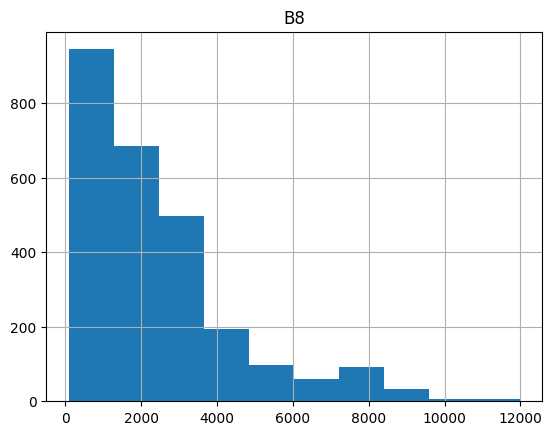

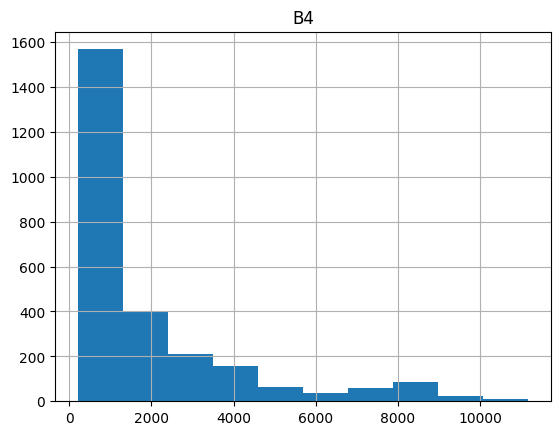

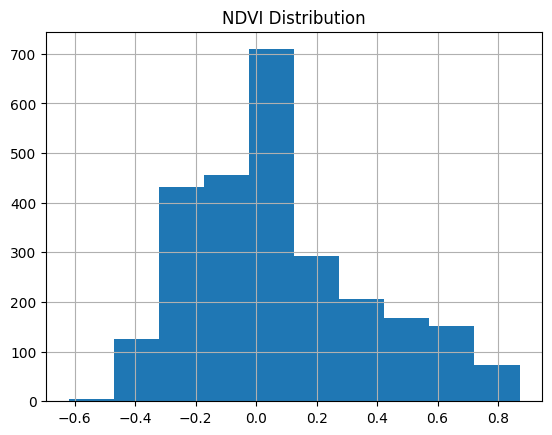

In [124]:
import matplotlib.pyplot as plt

X['B8'].hist()
plt.title('B8')
plt.show()
X['B4'].hist()
plt.title('B4')
plt.show()


z['NDVI'].hist()
plt.title('NDVI Distribution')
plt.show()

In [125]:
class MetaArchi(nn.Module):
    def __init__(self, args, input_shape):
        super().__init__()
        self.input_shape = input_shape
        assert isinstance(args['Dag'], AdjMatrix), f"The 'Dag' argument should be an 'AdjMatrix'. Got {type(args['Dag'])} instead."
        self.dag = args['Dag']
        self.dag.set(input_shape)


    def forward(self, X):
        return self.dag(X)
    def set_prediction_to_save(self, name, df):
        if hasattr(self, "prediction"):
            self.prediction[name] = df
        else:
            self.prediction = {name: df}
    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        full_path = os.path.join(path, "best_model.pth")
        torch.save(self.state_dict(), full_path)
        if hasattr(self, "prediction"):
            for k in self.prediction.keys():
                self.prediction[k].to_csv(os.path.join(path, f"best_model_{k}_outputs.csv"))

In [126]:
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_set = RegressionDataset(X, z)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [127]:
from dragon.search_operators.base_neighborhoods import CatInterval, ConstantInterval
from dragon.search_operators.dag_neighborhoods import EvoDagInterval, HpInterval
from dragon.search_space.base_variables import CatVar, Constant
from dragon.search_space.bricks.basics import Identity
from dragon.search_space.bricks.symbolic_regression import *
from dragon.search_space.dag_variables import EvoDagVariable, HpVar
from dragon.search_space.bricks_variables import (
    operations_var,
    dag_var,
)
from dragon.search_space.base_variables import ArrayVar
from dragon.search_space.dag_encoding import SymbolicNode
from dragon.search_operators.base_neighborhoods import ArrayInterval

unary_var = HpVar(
    "UnaryOp",
    CatVar(
        "UnaryOpType",
        features=[Identity, Inverse, Negate],
        neighbor=CatInterval()
    ),
    hyperparameters={},
    neighbor=HpInterval()
)
select_features_var = HpVar(
    "SelectFeatures",
    Constant("SelectFeaturesOp", SelectFeatures, neighbor=ConstantInterval()),
    hyperparameters={
        "feature_indices": CatVar(
            "feature_indices",
            features=[[0], [1]],
            neighbor=CatInterval()
        )
    },
    neighbor=HpInterval()
)

sum_var = HpVar(
    "Sum",
    Constant("SumOp", SumFeatures, neighbor=ConstantInterval()),
    hyperparameters={},
    neighbor=HpInterval()
)


candidate_operations = operations_var(
    "CandidateOperations",
    size=11,
    candidates=[
        select_features_var,
        unary_var,
        sum_var
    ],
    activations=Constant(
        "id",
        value=nn.Identity(),
        neighbor=ConstantInterval()
    ),
    node_type=SymbolicNode
)

dag = EvoDagVariable(
                    label="Dag",
                    operations = candidate_operations,
                    init_complexity=8,
                    neighbor=EvoDagInterval(nb_mutations=1)
                )


search_space = ArrayVar(dag, label="Search Space", neighbor=ArrayInterval())

# LOSS

#### Optimization of constants

In [128]:
def loader_to_tensors(loader, device):
    Xs, ys = [], []
    for Xb, yb in loader:
        Xs.append(Xb)
        ys.append(yb)
    X = torch.cat(Xs, dim=0).to(device)
    y = torch.cat(ys, dim=0).to(device)
    return X, y

def fit_constants_lbfgs(model, X, y, steps=50, lr=1.0):
    model.train()
    const_params = [p for n, p in model.named_parameters() if n.endswith(".value") and p.requires_grad]
    print(const_params)
    if not const_params:
        return

    criterion = nn.MSELoss()
    opt = torch.optim.LBFGS(const_params, lr=lr, max_iter=steps, line_search_fn="strong_wolfe")

    def closure():
        opt.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        if torch.isnan(loss) or torch.isinf(loss):
            return loss
        loss.backward()
        return loss

    opt.step(closure)


#### Custom loss

#### Pearson correlation

In [129]:
def correl(pred, true):
    """Calculates the Pearson correlation coefficient"""
    # Convert to numpy if needed
    if isinstance(pred, torch.Tensor):
        pred = pred.numpy()
    if isinstance(true, torch.Tensor):
        true = true.numpy()
    
    # Calculate deviations from mean
    pred_dev = pred - pred.mean()
    true_dev = true - true.mean()
    
    # Calculate covariance
    cov = np.sum(pred_dev * true_dev)
    
    # Calculate standard deviations
    std_pred = np.sqrt(np.sum(pred_dev ** 2))
    std_true = np.sqrt(np.sum(true_dev ** 2))
    
    # Return correlation coefficient
    if std_pred == 0 or std_true == 0:
        return 0.0
    return cov / (std_pred * std_true + 1e-8)

In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def eval(args, eps=1e-1,):
    model = MetaArchi(args, input_shape=(2,)).to(device)
    

    # # Optimization
    # rand = np.random.rand()
    # if rand > 0.5:
    #     X_train_full, y_train_full = loader_to_tensors(train_loader, device)
    #     fit_constants_lbfgs(model, X_train_full, y_train_full, steps=50, lr=1.0)

    model.eval()

    all_pred, all_true = [], []

    with torch.no_grad():
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb)
            all_pred.append(pred.detach().cpu())
            all_true.append(yb.detach().cpu())
    pred_all = torch.cat(all_pred)
    true_all = torch.cat(all_true)

    mse = np.inf
    selected_c = 0

    if len(pred_all.shape) > 1:
        for c in range(pred_all.shape[-1]):
            loss = 1 -(correl(pred_all[:, c:c+1], true_all))**2
            if loss < mse:
                mse = loss
                selected_c = c
        pred_all = pred_all[:, selected_c]

    pred_all = pred_all.squeeze().numpy()
    true_all = true_all.squeeze().numpy()



    close_matches = np.sum(np.abs(pred_all - true_all) < eps)
    fraction_close = close_matches / len(pred_all)
    var = np.abs(true_all.std() - pred_all.std())
    return model, pred_all, true_all, mse, fraction_close, var
    

def loss_function(args, idx, eps=1e-1, mse_threshold=0.04, *kwargs):
    labels = [e.label for e in search_space]
    args = dict(zip(labels, args))

    model, y_pred, y_true, mse, fraction_close, var = eval(args, eps)

    try:
        expr = graph_to_formula(
            args['Dag'].matrix,
            np.asarray(['B4', 'B8']),
            args['Dag'].operations
        )
    except Exception as e:
        expr = None

    print(
        f"Idx={idx}, MSE = {mse:.6f}, var={var:.6f} "
        f"fraction_close = {fraction_close:.4f}, "
        f"formula={expr}"
    )
    rand = np.random.rand()
    if rand > 0.5:
        if expr is not None:
            try:
                mini_dag = expr_to_mini_dag(expr, ["B4", "B8"])
                args['Dag'] = mini_dag
                model, y_pred, y_true, mse, fraction_close, var = eval(args, eps)
                expr = graph_to_formula(
                    args['Dag'].matrix,
                    np.asarray(['B4', 'B8']),
                    args['Dag'].operations
                )
                print(f"Idx={idx}, mini dag MSE={mse:.6f}, var = {var:.6f}, formula = {expr}")
            except Exception as e:
                pass
        model.mini_x = [v for v in args.values()]
    df = pd.DataFrame({
        "pred": y_pred,
        "true": y_true
    })
    model.set_prediction_to_save("prediction", df)
    return (mse+var).item(), model


In [136]:
from dragon.search_algorithm.mutant_ucb import Mutant_UCB

T_mut = 2000
K = int(0.5*T_mut)
save_dir="save/NDVI_formula/"
search_algorithm = Mutant_UCB(
    search_space=search_space,
    evaluation=loss_function,
    T=T_mut,
    K=K,
    N=1,
    E=1000,
    save_dir=save_dir,
    clean_all=False,
    verbose=True
)
search_algorithm.run()
# T_mut+=500
# search_algorithm = Mutant_UCB(
#     search_space=search_space,
#     evaluation=loss_function,
#     T=T_mut,
#     K=K,
#     N=1,
#     E=0.01,
#     save_dir=save_dir,
#     clean_all=False,
#     verbose=True,
#     pop_path=save_dir
# )
# search_algorithm.run()

2026-02-05 14:57:55,258 | WARNING | Install mpi4py if you want to use the distributed version.
2026-02-05 14:57:55,258 | INFO | save/NDVI_formula/ already exists. Deleting it.
2026-02-05 14:57:56,028 | INFO | The whole population has been created (size = 1000), 1000 have been randomy initialized.
Idx=0, MSE = 0.688325, var=0.290601 fraction_close = 0.3393, formula=(B4 + B8)**(-2)
2026-02-05 14:57:56,077 | INFO | Best found! 0.9789267182350159 < inf
Idx=1, MSE = 0.998657, var=6280.428711 fraction_close = 0.0000, formula=B4 + 2*B8
Idx=2, MSE = 0.965944, var=0.288544 fraction_close = 0.3378, formula=2/B8
Idx=3, MSE = 0.596442, var=0.288591 fraction_close = 0.3385, formula=1/B4
Idx=3, mini dag MSE=0.596442, var = 0.288591, formula = 1/B4
2026-02-05 14:57:56,206 | INFO | Best found! 0.8850334882736206 < 0.9789267182350159
Idx=4, MSE = 0.924731, var=2111.819092 fraction_close = 0.0000, formula=-B4
Idx=5, MSE = 0.596442, var=0.288591 fraction_close = 0.3385, formula=1/B4
2026-02-05 14:57:56,2

# Post - Processing

In [138]:
def post_process_alignment(best_model_dict, train_loader):
    """
    Post-processing step to align the best found formula with the true NDVI values 
    by finding optimal scaling (a1) and shifting (a0) coefficients.
    """
    # Reconstruct the PyTorch model from the dictionary
    model = MetaArchi(best_model_dict, input_shape=(2,)).to(device)
    model.eval()
    
    all_pred, all_true = [], []
    
    with torch.no_grad():
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb)
            all_pred.append(pred.detach().cpu())
            all_true.append(yb.detach().cpu())
    
    pred_all = torch.cat(all_pred)
    true_all = torch.cat(all_true)
    
    # Select the best output channel if there are multiple
    if len(pred_all.shape) > 1:
        best_corr = -np.inf
        selected_c = 0
        for c in range(pred_all.shape[-1]):
            R = correl(pred_all[:, c:c+1], true_all)
            if R > best_corr:
                best_corr = R
                selected_c = c
        pred_all = pred_all[:, selected_c]
    
    pred_all = pred_all.squeeze().numpy()
    true_all = true_all.squeeze().numpy()
    
    # Alignment : min |y_true - (a1*y_pred + a0)|
    A = np.column_stack([pred_all, np.ones_like(pred_all)])
    coeffs, _, _, _ = np.linalg.lstsq(A, true_all, rcond=None)
    a1, a0 = coeffs
    
    pred_aligned = a1 * pred_all + a0
    mse_final = np.mean((pred_aligned - true_all)**2)
    
    print(f"Post-processing alignment: a1={a1:.6f}, a0={a0:.6f}, MSE={mse_final:.6f}")
    
    return a1, a0, mse_final


# Load the best model
best_model_params = load_archi("save/NDVI_formula/best_model/x.pkl")
labels = [e.label for e in search_space]
best_model_dict = dict(zip(labels, best_model_params))
m_dag = best_model_dict['Dag'].matrix
n_dag = str_operations(best_model_dict["Dag"].operations)

# Get original formula
try:
    original_expr = graph_to_formula(
        best_model_dict['Dag'].matrix,
        np.asarray(['B4', 'B8']),
        best_model_dict['Dag'].operations
    )
    print(f"Original formula: {original_expr}")
except Exception as e:
    original_expr = None
    print(f"Error: {e}")

# Post-processing alignment
a1, a0, final_mse = post_process_alignment(best_model_dict, train_loader)

# Final aligned formula
if original_expr:
    final_formula = f"{a1:.6f} * ({original_expr}) + {a0:.6f}"
    print(f"Final aligned formula: {final_formula}")

Original formula: (-2*B4**2 + B4 + B8)/(B4*(B4 + B8))
Post-processing alignment: a1=-0.995594, a0=-0.993755, MSE=0.000002
Final aligned formula: -0.995594 * ((-2*B4**2 + B4 + B8)/(B4*(B4 + B8))) + -0.993755


Model giving a score of  99.87 %:


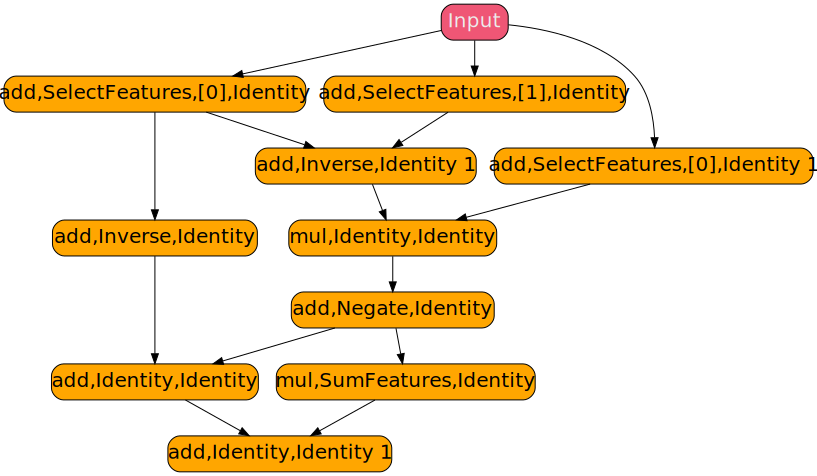

In [139]:
import graphviz
from dragon.utils.plot_functions import draw_cell, load_archi, str_operations

def draw_graph(n_dag, m_dag, output_file, best_model, act="Identity()", name="Input"):
    G = graphviz.Digraph(
        output_file,
        format='pdf',
        node_attr={
            'nodesep': '0.02',
            'shape': 'box',
            'rankstep': '0.02',
            'fontsize': '20',
            "fontname": "sans-serif"
        }
    )

    # Draw the DAG cells
    G, g_nodes = draw_cell(G, n_dag, m_dag, "#ffa600", [], name_input=name, color_input="#ef5675")

    return G

# Load the best model
best_model = load_archi("save/NDVI_formula/best_model/x.pkl")
labels = [e.label for e in search_space]
best_model = dict(zip(labels, best_model))
m_dag = best_model['Dag'].matrix
n_dag = str_operations(best_model["Dag"].operations)

# Draw the graph
graph = draw_graph(n_dag, m_dag, "save/_mutant/best_archi", best_model)
print(f'Model giving a score of ', np.round((1-search_algorithm.min_loss)*100, 2), '%:')
graph


In [140]:
m_dag = [SymbolicNode(combiner='add', operation=Identity, hp = {}, activation=nn.Identity()), 
         SymbolicNode(combiner='add', operation=SelectFeatures, hp={'feature_indices': [0]}, activation=nn.Identity()), 
         SymbolicNode(combiner='add', operation=SelectFeatures, hp={'feature_indices': [1]}, activation=nn.Identity())]
n_dag = np.array([[0, 1, 1],
                  [0, 0, 0],
                  [0, 0, 0],
                  ])

minimal_graph = [AdjMatrix(matrix=n_dag, operations=m_dag)]

AssertionError: Node 1 does not have any outgoing connections.

In [141]:
from dragon.utils.plot_functions import load_archi, graph_to_formula

best_model = load_archi(f"{save_dir}/best_model/x.pkl")
labels = [e.label for e in search_space]
best_model = dict(zip(labels, best_model))
expr = graph_to_formula(best_model['Dag'].matrix, np.asarray(['B4', 'B8']), best_model['Dag'].operations)
expr

(-2*B4**2 + B4 + B8)/(B4*(B4 + B8))